# División de Ciencias e Ingenierías de la Universidad de Guanajuato
## Fundamentos de procesamiento digital de imágenes
## TAREA : Funciones de filtrado en frecuencia
### Profesor : Dr. Arturo González Vega
### Alumno : Gustavo Magaña López

In [3]:

import copy
from typing import Tuple, List

import numpy as np
import scipy.fftpack as F
import scipy.io as io

import cv2
import matplotlib.image as img

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

import skimage
import skimage.morphology
import skimage.filters

In [4]:
eps = np.finfo(float).eps
eps.setflags(write=False)

In [5]:
plt.rcParams['figure.figsize'] = (10, 10)

In [24]:
def img_surf(image: np.ndarray) -> None:
    """
    """
    fig  = plt.figure()
    ax   = fig.gca(projection='3d')
    x, y = list(map(lambda x: np.arange(0, x), image.shape))
    X, Y = np.meshgrid(x, y)
    #U, V = fourier_meshgrid(image)
    #print(f'Shapes X:{X.shape}\n Y:{Y.shape}\n Z:{Z.shape}')

    surf = ax.plot_surface(X, Y, image.T, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
    
    plt.show()
##

def img_fft(image: np.ndarray, shift: bool = True) -> np.ndarray:
    """
        Ejecutar una Transformada de Fourier visualizable con matplotlib.pyplot.imshow() .
        
        Basado en un snippet encontrado en :
        https://medium.com/@y1017c121y/python-computer-vision-tutorials-image-fourier-transform-part-2-ec9803e63993
        
        Parámetros :
                image : Imagen, representada como un arreglo de numpy (numpy.ndarray)
                shift : Booleano que indica si debe ejecutarse la traslación de la imagen e
                        en el espacio de frecuencia.
    """
    _X = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    if shift:
        _X_shift = np.fft.fftshift(_X)
    _X_complex = _X_shift[:,:,0] + 1j*_X_shift[:,:,1]
    _X_abs = np.abs(_X_complex) + 1 # Evitar que el logaritmo reciba 0 como argumento.
    _X_bounded = 20 * np.log(_X_abs)
    _X_img = 255 * _X_bounded / np.max(_X_bounded)
    _X_img = _X_img.astype(np.uint8)
    
    return _X_img
##

def fft_viz(image: np.ndarray, shift: bool = True) -> None:
    """
        Ver la transformada de fourier de una imagen.
    """
    plt.figure()
    plt.imshow(img_fft(image, shift=shift), cmap='gray')
    plt.show()
##

def pre_fft_processing(
    image: np.ndarray,
      top: int = None,
   bottom: int = None, 
     left: int = None,
    right: int = None,
    borderType: int = None,
) -> np.ndarray:
    """
        Esta función lleva a cabo el proceso de 'padding', necesario antes 
        de aplicar un filtrado en el espacio frecuencial (de Fourier).
        
        Básicamente un wrapper para :
            cv2.copyMakeBorder( image, top, bottom, left, right, borderType)
            
        Donde el tipo de frontera (borderType) puede ser alguno de los siguientes :
            cv2.BORDER_CONSTANT
            cv2.BORDER_REFLECT
            cv2.BORDER_REFLECT_101
            cv2.BORDER_DEFAULT
            cv2.BORDER_REPLICATE
            cv2.BORDER_WRAP
        
        Si faltan uno o más de los parámetros necesarios para llamar cv2.copyMakeBorder(), 
        se implementará un 'padding' por defecto en función de los valores calculados por
        cv2.getOptimalDFTSize().
        
    ##  Parámetros :
                image : Una imagen en blanco y negro, es decir un arreglo bidimensional de numpy.
                  top : Número entero representando el número de pixeles que se agegarán en el margen superior.
               bottom : idem. para el margen inferior. 
                 left : idem. para el margen izquierdo.
                right : idem. para el margen derecho.
           borderType : Alguno de los mencionados anteriormente en el Docstring.


                
    ##  Regresa :
                nimg  : imagen con 'padding'
    """
    override = all(map(lambda x: x if x != 0 else True, [top, bottom, left, right, borderType]))
    if override:
        nimg = cv2.copyMakeBorder(image, top, bottom, left, right, bordertype)
    else:
        rows, cols = image.shape
        nrows, ncols = list(map(cv2.getOptimalDFTSize, image.shape))
        right = ncols - cols
        bottom = nrows - rows
        bordertype = cv2.BORDER_CONSTANT #just to avoid line breakup in PDF file
        nimg = cv2.copyMakeBorder(image,0,bottom,0,right,bordertype, value = 0)
    
    return nimg
##

def fft2(
    image: np.ndarray,       
      top: int = None,
   bottom: int = None, 
     left: int = None,
    right: int = None,
    borderType: int = None,
) -> np.ndarray:
    """
    
    Execute:
        x = pre_fft_processing(image, top=top, bottom=bottom, left=left, right=right, borderType=borderType)
        return cv2.dft(np.float32(x),flags=cv2.DFT_COMPLEX_OUTPUT)
        
    Call the cv2's dft, which is supposed to be considerably faster than numpy's implementation.

    See help(pre_fft_processing) for futher details on the preprocessing stage.
    
    """
    nimg = pre_fft_processing(image, top=top, bottom=bottom, left=left, right=right, borderType=borderType)
    dft2 = cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
    
    return dft2
##

def ImPotencia(image: np.ndarray) -> float:
    """
        Calcula la potencia de acuerdo al teorema de Parseval.
    """
    _F = np.fft.fft2(image)
    return np.sum(np.abs(_F)**2) / np.prod(_F.shape)
##

def fourier_meshgrid(image: np.ndarray) -> Tuple[np.ndarray]:
    """
        Genera los arreglos bidimensionales U y V necesarios para poder hacer tanto
        filtrado en frecuencias como la visualización de imágenes en forma de superficies.
        Esto se hace mapeando las intensidades a los valores que tomará la función en el eje
        Z, dados los valores de X y Y que son las coordenadas de los pixeles.
        
    
    Parámetros :
        imagen : Arreglo bidimensional de numpy (numpy.ndarray), es decir una imagen.
        
    Regresa :
        (U, V) : Tuple contieniendo dos arreglos bidimensionales de numpy (numpy.ndarray)
    """
    M, N = image.shape
    u, v = list(map(lambda x: np.arange(0, x), image.shape))
    idx, idy = list(map(lambda x, y: np.nonzero(x > y/2), [u, v], image.shape))
    u[idx] -= M
    v[idy] -= N
    V, U = np.meshgrid(v, u)
    
    return U, V
##

def fourier_distance(U: np.ndarray, V: np.ndarray, centered: bool = True, squared: bool = True) -> np.ndarray:
    """
        Calcula la distancia euclidiana de los puntos de una malla (meshgrid), respecto al centro.
        Por defecto desplaza el centro (distancia 0) al centro de la matriz.
        Asimismo devuelve la distancia al cuadrado puesto que en ocaciones dicho cálculo se hace después
        y calcular la raíz y después elevar al cuadrado sería sólo perder tiempo de cómputo.
        
    Parámetros :
    
                U : Arreglo bidimensional de numpy (numpy.ndarray). 
                V : Idem.
         centered : Booleano indicando si se desea la distancia centrada, 
                    es decir ejecutar np.fft.fftshift(Distancia) una vez calculada
                    la matriz de distancias. 
                        True por defecto.
                        
          squared : Booleano indicando si se desea la distancia al cuadrado 
                    o la distancia euclidiana clásica.
                        True por defecto.
    
    Regresa :
               _d : Matriz con las distancias euclidianas, 
                    de cada coordenada respecto al centro.
    """
    _d = U**2 + V**2
    if not squared:
        _d = np.sqrt(_d)
    if centered:
        _d = np.fft.fftshift(_d)
    
    return _d
##

def _param_check(kind: str, Do: int) -> bool:
    """
        Para reducir la redundancia en el cuerpo de las funciones, 
        esta función verifica que :
        1.- La formulación especificada 'kind' sea válida.
            i.e. Alguna de las siguientes :
                'low', 'lowpass', 'low pass',
                'high', 'highpass', 'high pass',
                'bandpass', 'bandstop', 
                'band pass', 'band stop'
        2.- Que el parámetro `frecuencia de corte`, es decir
            Do o sigma, sea positivo.
    
    Parámetros :
            kind : string, tipo de filtro.
              Do : int, valor de la frecuencia de corte (distancia en el espacio de Fourier)
              
    Regresa :
            True  : Si se cumplen ambas condiciones.
            False : Si no. 
        
    """
    _kinds = [
        'low', 'high', 'lowpass', 'highpass', 
        'low pass', 'high pass',
        'bandpass', 'bandstop', 
        'band pass', 'band stop'
    ]
    kind = kind.lower()
    _kind_check = kind in _kinds
    _dist_check = Do > 0
    
    return _kind_check and _dist_check
##

def kernel_ideal(
    image: np.ndarray, 
       Do: int = 15, 
     kind: str = 'low',
        w: int = None,
      wc1: int = None, 
      wc2: int = None,
) -> np.ndarray:
    """
        Calcula un kernel ideal para una imagen dada.
    """
    
    assert _param_check(kind, Do), 'Tipo de filtro o frecuencia de corte inválidas.' 
    
    bandas = all(map(lambda x: x if x != 0 else True, [wc1, wc2]))
    print(f'bandas = {bandas}')
    
    U, V = fourier_meshgrid(image)
    D = fourier_distance(U, V)
    H = np.zeros_like(D)
    
    if 'low' in kind:
        _mask = np.nonzero(D <= Do)
        H[_mask] = 1.0
    elif 'high' in kind:
        _mask = np.nonzero(D > Do)
        H[_mask] = 1.0
    else:
        _err_msg  = "Para ejecutar un filtro pasa-bandas o de rechazo de banda,"
        _err_msg += "especificar una de las siguientes combinaciones de parámetros :"
        _err_msg += "\n\t\t 1.- Do y w \n\t\t 2.- wc1y wc2."
        assert w or bandas, _err_msg
        if w:
            wc1 = Do - w/2
            wc2 = Do + w/2
        else:
            assert wc1 < wc2, f'Valores wc1 = {wc1}, wc2 = {wc2} no cumplen la condición wc1 < wc2.'
        if 'pass' in kind:
            _mask = np.nonzero((D >= wc1) & (D <= wc2))
            H[_mask] = 1.0
        elif 'stop' in kind:
            _mask = np.nonzero((D < wc1) | (D > wc2))
            H[_mask] = 1.0
    
    return H
##

def kernel_butterworth(
    image: np.ndarray, 
       Do: int = 15, 
     kind: str = 'low',
        n: int = 1,
        w: int = None,
      wc1: int = None, 
      wc2: int = None,
) -> np.ndarray:
    """
        Calcula un kernel tipo Butterworth para una imagen dada.
    """
    assert _param_check(kind, Do), 'Tipo de filtro o frecuencia de corte inválidas.' 
    assert n in range(1,10+1), f'Error: n (= {n}) no se encuentra en el rango [1,10]'
    
    bandas = all(map(lambda x: x if x != 0 else True, [wc1, wc2]))
    if bandas:
        assert wc1 < wc2, f'Valores wc1 = {wc1}, wc2 = {wc2} no cumplen wc1 < wc2.'
        Do = np.ceil((wc2 + wc1) / 2.0)
        w  = np.ceil(2.0 * (wc2 - Do))
    
    U, V = fourier_meshgrid(image)
    D = fourier_distance(U, V)
    H = np.zeros_like(D)
    
    if 'low' in kind:
        H = 1.0 / 1.0 + (D/Do**2)**n
    elif 'high' in kind:
        H = 1.0 / 1.0 + (Do**2/D)**n
    elif 'pass' in kind:
        w2 = w**2
        H = 1.0 / 1.0 + ( (D - Do**2)**2 / (w2 * D + eps) )**n
    elif 'stop' in kind:
        w2 = w**2
        H = 1.0 / 1.0 + ( (w2 * D) / (D - Do**2 + eps)**2 )**n
    
    return H
##

def kernel_gaussiano(
    image: np.ndarray, 
    sigma: int = 15, 
     kind: str = 'low',
        w: int = None,
      wc1: int = None, 
      wc2: int = None,
) -> np.ndarray:
    """
        Calcula un kernel gaussiano para una imagen dada.
    """
    
    assert _param_check(kind, sigma), 'Tipo de filtro o frecuencia de corte inválidas.' 
    
    bandas = all(map(lambda x: x if x != 0 else True, [wc1, wc2]))
    if bandas:
        assert wc1 < wc2, f'Valores wc1 = {wc1}, wc2 = {wc2} no cumplen wc1 < wc2.'
        sigma = np.ceil((wc2 + wc1) / 2.0)
        w     = np.ceil(2.0 * (wc2 - sigma))
    
    U, V = fourier_meshgrid(image)
    D = fourier_distance(U, V)
    # ^^^ Esta D son distancias al cuadrado, véase help(fourier_distance)
    
    if 'band' not in kind: 
        # Si 'band' no está contenido en el tipo, será pasabajos o pasaaltos.
        # Filtros pasa bajos y pasa altos :
        H = np.exp( (-1.0 * D) / (2.0 * sigma**2) ) 
        if 'high' in kind:
            H = 1.0 - H
    else:
        # Además de la bandera, se requiere verificar que wc1, wc2 sean distancias de
        # corte válidas para el diseño del filtro.
        # Filtros pasa-bandas y rechazo de bandas.
        bandas = all(map(lambda x: x if x != 0 else True, [wc1, wc2]))
        if bandas:
            assert wc1 < wc2, f'Valores wc1 = {wc1}, wc2 = {wc2} no cumplen wc1 < wc2.'
            sigma = np.ceil((wc2 + wc1) / 2.0)
            w     = np.ceil(wc2 - sigma)
        else:
            assert type(w) is int, f'type(w) = {type(w)}, should be int.'
            assert w > 0, f'w = {w}, should be greater than zero'
        H = np.exp(
            -1.0 * np.power(
                (D - sigma**2) / (w * np.sqrt(D)), 2
            )
        ) 
        if 'stop' in kind:
            H = 1.0 - H
        
    return H
##

def muestra_kernels_gaussianos(
    sigma: int = 16, 
      wc1: int = 54, 
      wc2: int = 74,
) -> None:
    """
    """
    
    _dummy = np.zeros((500, 500))
    
    plt.subplot(2, 2, 1)
    plt.imshow(kernel_gaussiano(_dummy, kind='low'), cmap='gray')
    plt.title(f'Pasa bajos : sigma = {sigma}')
    
    plt.subplot(2, 2, 2)
    plt.imshow(kernel_gaussiano(_dummy, kind='high'), cmap='gray')
    plt.title(f'Pasa altos : sigma = {sigma}')
    
    plt.subplot(2, 2, 3)
    plt.imshow(kernel_gaussiano(_dummy, kind='bandstop', wc1=wc1, wc2=wc2), cmap='gray')
    plt.title(f'Rechazo de bandas : wc1 = {wc1}, wc2 = {wc2}')
    
    plt.subplot(2, 2, 4)
    plt.imshow(kernel_gaussiano(_dummy, kind='bandpass', wc1=wc1, wc2=wc2), cmap='gray')
    plt.title(f'Pasa bandas, wc1 = {wc1}, wc2 = {wc2}')
    
    
    
    
def FiltraGaussiana(image: np.ndarray, sigma: float, kind: str = 'low') -> np.ndarray:
    """
    
    """
    kind   = kind.lower()
    _kinds = ['low', 'high', 'lowpass', 'highpass']
    if kind not in _kinds:
        raise Exception(f'Error : Tipo desconocido de filtro \"{kind}\".\n Tipos disponibles : {_kinds}')
    
    H  = kernel_gaussiano(image=image, sigma=sigma, kind=kind)
    _F = np.fft.ifftshift(
            np.fft.fft2(image)
    )
    G  = H * _F
    g  = np.real( np.fft.ifft2( np.fft.ifftshift(G) ))
    
    # Recortamos la imagen a su tamaño original, de ser requerido.
    g = g[:image.shape[0], :image.shape[1]]  
        
    return g  
##

def filtro_disco(image: np.ndarray, radius: int = 5) -> np.ndarray:
    """
    
    """
    _circle = skimage.morphology.disk(radius)
    _filtered = skimage.filters.rank.mean(copy.deepcopy(image), selem=_circle)
    return _filtered
##


In [8]:
I = img.imread('imagenes/mama.tif')
#plt.imshow(I, cmap='gray')

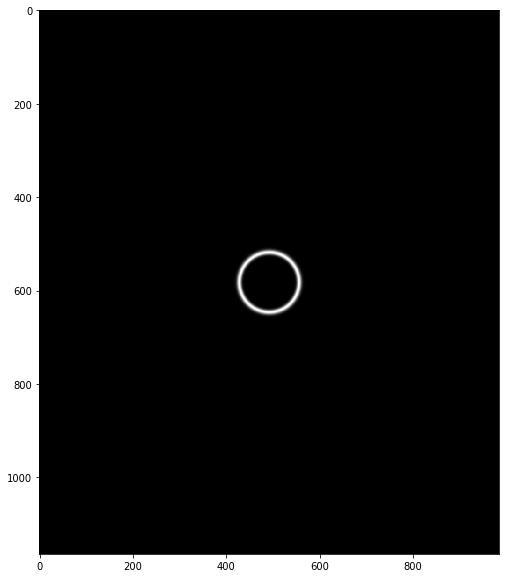

In [9]:
plt.imshow(kernel_gaussiano(I, kind='bandpass', wc1=54, wc2=74), cmap='gray')

In [10]:
x = np.zeros_like(I)

In [11]:
#help(np.zeros)
y = np.zeros((500, 500), )

In [13]:
#plt.imshow(y, cmap='gray')

In [14]:
x.shape

(1164, 984)

In [16]:
# fft2(I)

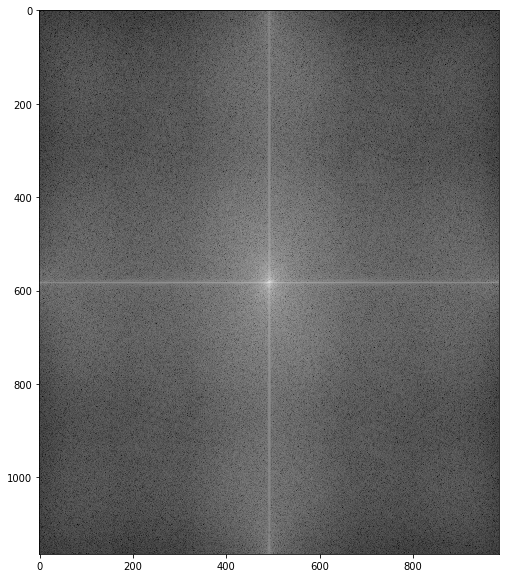

In [17]:
fft_viz(I)

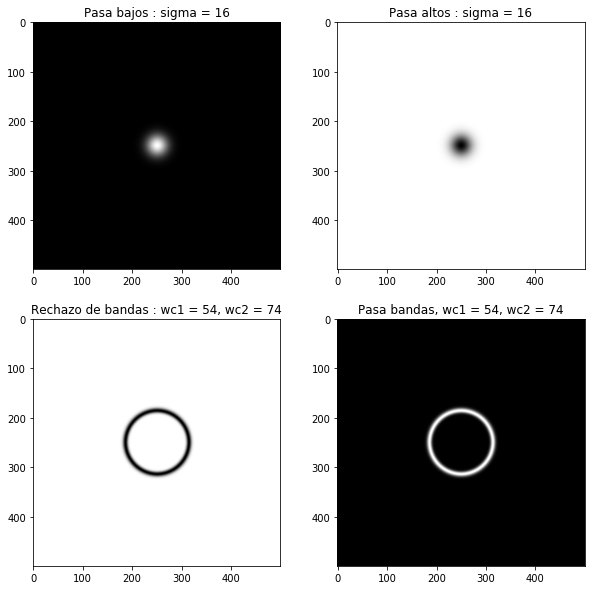

In [18]:
muestra_kernels_gaussianos()

In [19]:
#plt.imshow(FiltraGaussiana(I, sigma=3), cmap='gray')

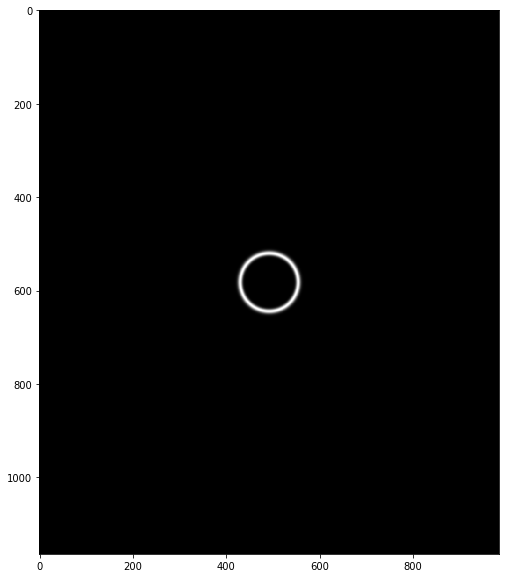

In [20]:
_tmp = kernel_gaussiano(I, kind='bandpass', wc1=52, wc2=72)
plt.imshow(_tmp, cmap='gray')

bandas = False


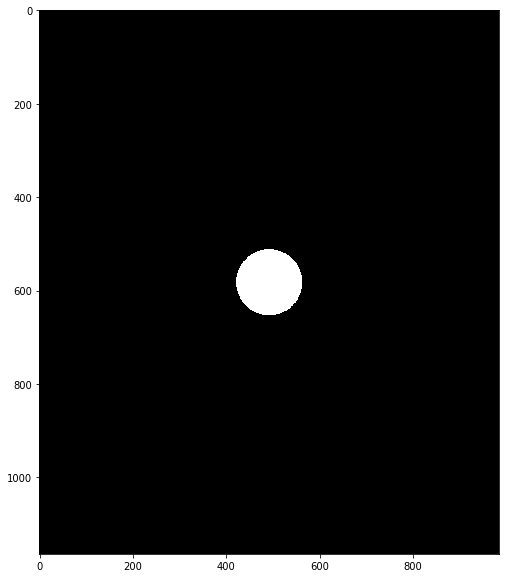

In [21]:
plt.imshow(kernel_ideal(I, Do=5000, kind='low'), cmap='gray')

In [55]:
f = lambda x: True if x > 5 else False

In [57]:
assert f(6), 'No es mayor a 5'

/usr/local/anaconda3/envs/image/lib/python3.7/site-packages/ipykernel_launcher.py:359: RuntimeWarning: divide by zero encountered in true_divide


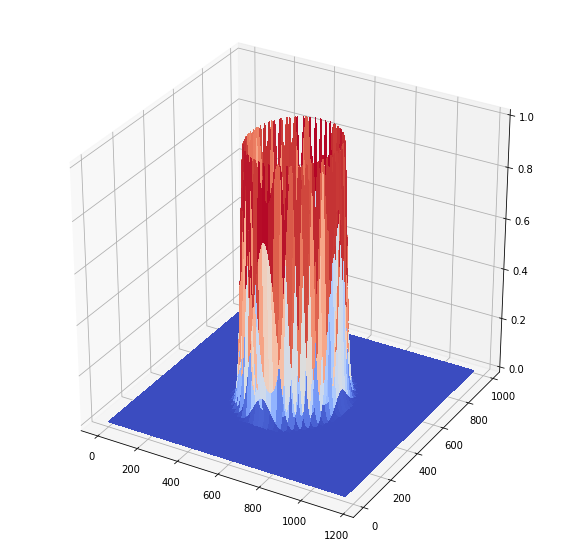

In [26]:
img_surf(kernel_gaussiano(I, kind='bandpass', sigma=200, w=40))

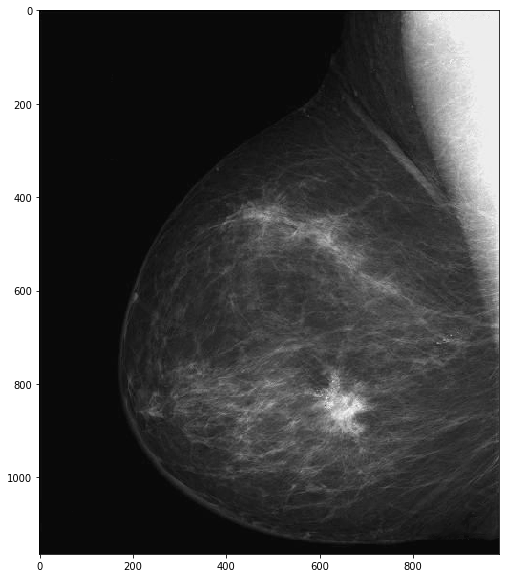

In [28]:
plt.imshow(I, cmap='gray')